In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string

import sys
#!{sys.executable} -m pip install gensim
import gensim

#!{sys.executable} -m pip install textblob
from textblob import Word

#!{sys.executable} -m pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt

#!{sys.executable} -m pip install seaborn
import seaborn as sns

from PIL import Image

#!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
news_df = pd.read_csv('./bbc-text.csv')

In [3]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [4]:
news_df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [5]:
# index category names
news_df['category_id'] = news_df['category'].factorize()[0]

In [6]:
# unique categories dataframe
category_id_df = news_df[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [7]:
# convert category names to index number from dictionary
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [8]:
id_to_category
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


<AxesSubplot:xlabel='category'>

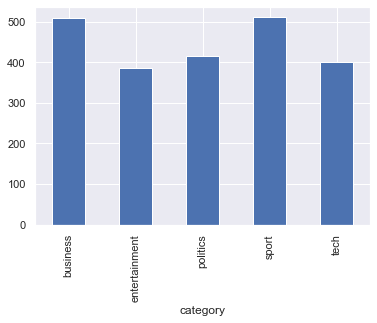

In [9]:
news_df.groupby('category').category_id.count().plot.bar(ylim=0)

In [10]:
news_df.drop_duplicates(subset=['category', 'text'], inplace=True)

In [11]:
# Cleaning
def clean_text(text):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    # remove whitespaces
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [12]:
# clean text feature
news_df['clean_text'] = news_df['text'].apply(clean_text).str.replace('bn bn ', '')

# other clean text feature
news_df['clean_text'] = news_df['text'].apply(clean_text).str.replace(' bn ', '')

In [13]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

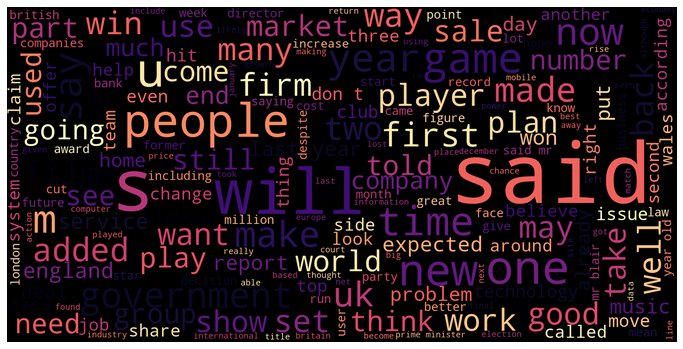

In [15]:
text = " ".join(review for review in news_df.clean_text)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

In [14]:
# Lemmatize words
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [15]:
# Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)

features = tfidf_vec.fit_transform(news_df.clean_text).toarray()
                                                  
labels = news_df.category_id

In [16]:
features.shape # identified features from tfidf

(2126, 10000)

In [17]:
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [18]:
news_df.to_csv('out_df.csv', index=False)

In [19]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # top 3 categories

# highly corelated words for each category
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . oil
       . bank
  . Most correlated bigrams:
       . oil price
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . band
       . award
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . mr brown
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . champion
       . cup
       . match
  . Most correlated bigrams:
       . australian open
       . champion league
       . grand slam
# 'tech':
  . Most correlated unigrams:
       . technology
       . user
       . mobile
  . Most correlated bigrams:
       . high definition
       . mobile phone
       . e mail


In [20]:
X = news_df.loc[:,'clean_text']
y = news_df.loc[:,'category_id']

In [21]:
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, news_df.index, test_size=0.2, random_state=55)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.25, random_state=10)
X_test

1704    brainwave cap controls computer a team of us r...
679     davenport puts retirement on hold lindsay dave...
881     uk youth interested in politics the majority o...
1273    millions to miss out on the net by of the uk s...
1656    egypt and israel seal trade deal in a sign of ...
                              ...                        
1565    ferdinand casts doubt over glazer rio ferdinan...
2052    renault boss hails great year strong sales out...
2169    goldsmith denies war advice claim the attorney...
260     ukip outspent labour on eu poll the uk indepen...
1474    lufthansa may sue over bush visit german airli...
Name: clean_text, Length: 426, dtype: object

In [22]:
# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
#xcv_tfidf = tfidf_vec.fit_transform(X_cv)

In [23]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)
xtest_cv

<426x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 52860 stored elements in Compressed Sparse Row format>

In [24]:
perform_list = []

In [37]:
testing = "the president doesn't know what he'd do to change america and the election"
frame = {0:testing}
ser = pd.Series(data=frame)
ser
test = tfidf_vec.transform(ser)

testcv = count_vec.transform(ser)

In [38]:
mdl = LinearSVC()
oneVsRest = OneVsRestClassifier(mdl)
oneVsRest.fit(xtrain_tfidf, y_train)
y_pred = oneVsRest.predict(test)
print(y_pred) # SUCCESS

[4]


In [30]:
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)        

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [31]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 96.71
Precision : 0.9671361502347418
Recall    : 0.9671361502347418
F1-score   : 0.9671361502347418


In [32]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 96.95
Precision : 0.9694835680751174
Recall    : 0.9694835680751174
F1-score   : 0.9694835680751174


In [33]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 96.71
Precision : 0.9671361502347418
Recall    : 0.9671361502347418
F1-score   : 0.9671361502347418


In [ ]:
run_model('Linear SVC', est_c=None, est_pnlty=None)

In [ ]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance